In [1]:
import os

import psycopg
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow

TABLE_NAME = "users_churn" # таблица с данными в postgres 

TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

EXPERIMENT_NAME = "eda_volkovandrey" # напишите название вашего эксперимента
RUN_NAME = "eda"

ASSETS_DIR = "assets"

# Check if the directory exists, if not, create it
if not os.path.exists(ASSETS_DIR):
    os.mkdir(ASSETS_DIR)

pd.options.display.max_columns = 100
pd.options.display.max_rows = 64

sns.set_style("white")
sns.set_theme(style="whitegrid")

In [2]:
from dotenv import load_dotenv
load_dotenv()

# connection = {
#     "sslmode": "verify-full",
#     "sslrootcert": "system",
#     "target_session_attrs": "read-write"
# }
# connection = {"sslmode": "verify-full", "target_session_attrs": "read-write"}
connection = {
    "sslmode": "require",  # or "disable"
    "target_session_attrs": "read-write"
}
postgres_credentials = {
    "host": os.getenv("DB_DESTINATION_HOST"),
    "port": os.getenv("DB_DESTINATION_PORT"),
    "dbname": os.getenv("DB_DESTINATION_NAME"),
    "user": os.getenv("DB_DESTINATION_USER"),
    "password": os.getenv("DB_DESTINATION_PASSWORD"),
}

connection.update(postgres_credentials)

with psycopg.connect(**connection) as conn:

    with conn.cursor() as cur:
        cur.execute(f"SELECT * FROM {TABLE_NAME}")
        data = cur.fetchall()
        columns = [col[0] for col in cur.description]

df = pd.DataFrame(data, columns=columns)

df.head(2)

,id,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,target
0,5851,6927-WTFIV,2018-04-01,2019-12-01,Month-to-month,No,Credit card (automatic),71.3,1389.2,Fiber optic,No,No,No,No,No,No,Male,1,No,No,No,1
1,5852,4118-CEVPF,2017-03-01,NaT,One year,Yes,Bank transfer (automatic),110.8,3836.3,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Female,1,No,No,Yes,0


Задание 1
Постройте графики количества уникальных пользователей (customer_id), распределённых по таким группам:
пользователи по различным type,
пользователи по различным payment_method,
пользователи по различным internet_service,
пользователи по различным gender.
Создайте одну фигуру размером 16.5x12.5 с четырьмя графиками по списку выше. Сохраните вашу картинку в директорию ASSETS_DIR, а файл назовите cat_features_1.

/tmp/ipykernel_15701/2639426444.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1, 0].set_xticklabels(agg_df[x], rotation=45)


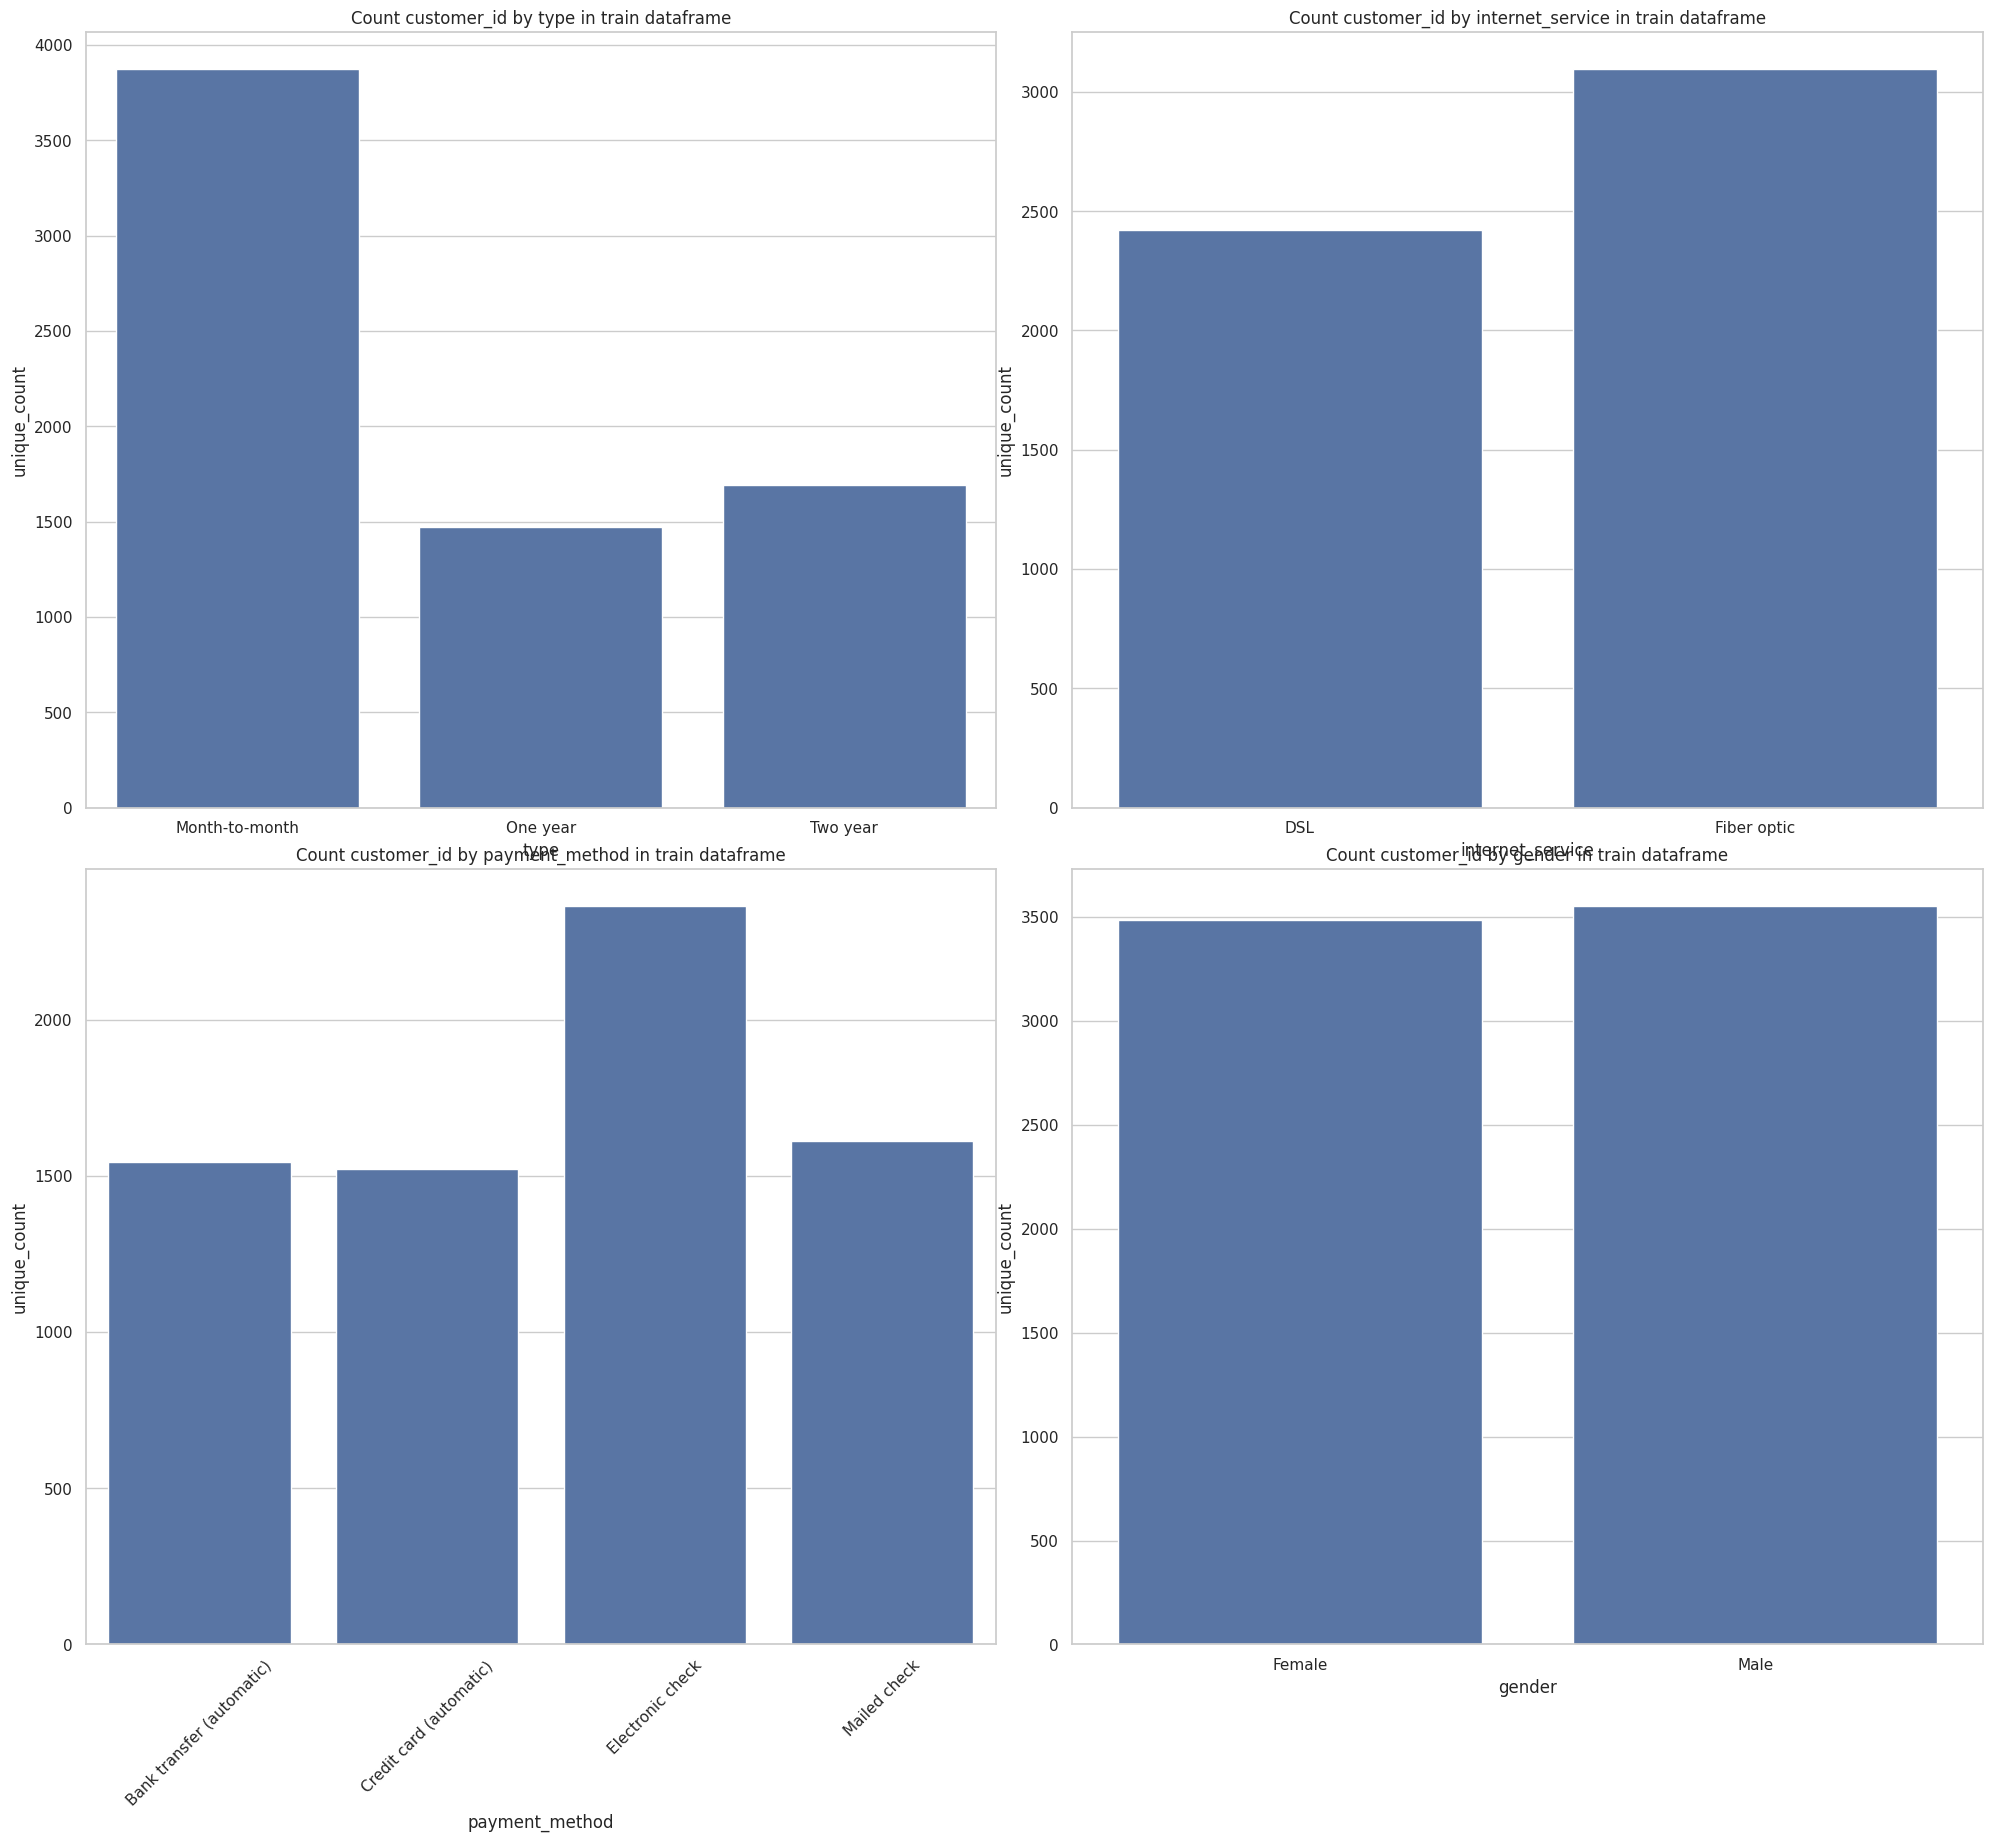

In [3]:
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(20, 17, forward=True)
fig.tight_layout(pad=1.6)


# Plot for 'type'
x = "type"
y = "customer_id"
stat = ["count"]
agg_df = df.groupby(x)[y].nunique().reset_index(name='unique_count')
sns.barplot(data=agg_df, x=x, y='unique_count', ax=axs[0, 0])
axs[0, 0].set_title(f'Count {y} by {x} in train dataframe')

# Plot for 'payment_method'
x = "payment_method"
y = "customer_id"
agg_df = df.groupby(x)[y].nunique().reset_index(name='unique_count')
sns.barplot(data=agg_df, x=x, y='unique_count', ax=axs[1, 0])
axs[1, 0].set_title(f'Count {y} by {x} in train dataframe')
axs[1, 0].set_xticklabels(agg_df[x], rotation=45)

# Plot for 'internet_service'
x = "internet_service"
y = "customer_id"
agg_df = df.groupby(x)[y].nunique().reset_index(name='unique_count')
sns.barplot(data=agg_df, x=x, y='unique_count', ax=axs[0, 1])
axs[0, 1].set_title(f'Count {y} by {x} in train dataframe')

# Plot for 'gender'
x = "gender"
y = "customer_id"
agg_df = df.groupby(x)[y].nunique().reset_index(name='unique_count')
sns.barplot(data=agg_df, x=x, y='unique_count', ax=axs[1, 1])
axs[1, 1].set_title(f'Count {y} by {x} in train dataframe')

# Save the figure to the specified directory
plt.savefig(os.path.join(ASSETS_DIR, 'cat_features_1.png'))

plt.show()

**Задание 2**

Постройте таблицу-воронку для бинарных колонок с подсчётом количества уникальных пользователей (`count`). Отсортируйте их по убыванию и выведите первые 10 строк.

In [4]:
x = "customer_id"
binary_columns = [
    "online_security", 
    "online_backup", 
    "device_protection", 
    "tech_support",
    "streaming_tv",
    "streaming_movies",
    "senior_citizen",
    "partner",
    "dependents",
]
stat = ['count']

df.groupby(binary_columns).agg(stat[0])[x].reset_index().sort_values(by=x, ascending=False).head(10)

,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,senior_citizen,partner,dependents,customer_id
0,No,No,No,No,No,No,0,No,No,371
106,No,Yes,No,No,No,No,0,No,No,105
414,Yes,Yes,Yes,Yes,Yes,Yes,0,Yes,Yes,103
4,No,No,No,No,No,No,1,No,No,101
8,No,No,No,No,No,Yes,0,No,No,90
15,No,No,No,No,Yes,No,0,No,No,86
214,Yes,No,No,No,No,No,0,No,No,83
22,No,No,No,No,Yes,Yes,0,No,No,82
413,Yes,Yes,Yes,Yes,Yes,Yes,0,Yes,No,75
3,No,No,No,No,No,No,0,Yes,Yes,68


**Задание 3**

Большие таблицы не всегда легко анализировать. Чтобы ускорить этот процесс, можно построить тепловую карту бинарных признаков. Ваша задача — построить её для тех же бинарных признаков. По оси 
x
x у вас должны быть значения 
0
0, 
1
1 по оси 
y
y — названия признаков. В конце сохраните получившийся график в директорию с артефактами с названием `cat_features_2_binary_heatmap`.

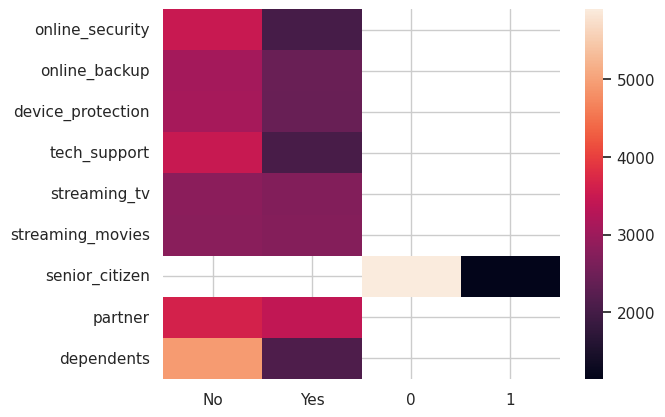

In [5]:
heat_df = df[binary_columns].apply(pd.Series.value_counts).T
sns.heatmap(heat_df)
plt.savefig(os.path.join(ASSETS_DIR, 'cat_features_2_binary_heatmap'))

**Задание 4**

Постройте два графика для `monthly_charges` и `total_charges`, а затем посчитайте средние значение, медиану и моду для каждого `begin_date` на них. Получившийся график сохраните с названием `charges_by_date`.

In [6]:
# инициализация переменной для названия колонки
x = "begin_date"

# список колонок, для которых будут вычисляться статистики
charges_columns = [
    "monthly_charges",
    "total_charges",
]

# удаление пустых колонок для посчёта медианного значения
df[charges_columns].dropna(inplace=True)

# список статистик, которые будут вычисляться для каждой группы
stats = ["mean", "median", lambda x: x.mode().iloc[0]]  # среднее значение, медиана и мода

# группировка данных по дате начала и агрегация статистик для ежемесячных платежей (используйте reset_index для сброса индекса в таблице)
charges_monthly_agg = df[[x] + [charges_columns[0]]].groupby([x]).agg(stats).reset_index()
# удаление верхнего уровня индекса колонок (после агрегации)
charges_monthly_agg.columns = charges_monthly_agg.columns.droplevel()
# переименование колонок для удобства восприятия
charges_monthly_agg.columns = [x, "monthly_mean", "monthly_median", "monthly_mode"]

# аналогично для общих платежей
charges_total_agg = df[[x] + [charges_columns[1]]].groupby([x]).agg(stats).reset_index()
charges_total_agg.columns = charges_total_agg.columns.droplevel()
charges_total_agg.columns = [x, "total_mean", "total_median", "total_mode"]

# создание объекта для отображения графиков (2 графика вертикально)
fig, axs = plt.subplots(2, 1)
# настройка отступов между графиками
fig.tight_layout(pad=2.5)
# установка размера фигуры
fig.set_size_inches(6.5, 5.5, forward=True)

# построение линейных графиков для ежемесячных платежей
sns.lineplot(charges_monthly_agg, ax=axs[0], x=x, y='monthly_mean')
sns.lineplot(charges_monthly_agg, ax=axs[0], x=x, y='monthly_median')
sns.lineplot(charges_monthly_agg, ax=axs[0], x=x, y='monthly_mode')
# установка заголовка для верхнего графика
axs[0].set_title(f"Count statistics for {charges_columns[0]} by {x}")

# построение линейных графиков для общих платежей
sns.lineplot(charges_total_agg, ax=axs[1], x=x, y='total_mean')
sns.lineplot(charges_total_agg, ax=axs[1], x=x, y='total_median')
sns.lineplot(charges_total_agg, ax=axs[1], x=x, y='total_mode')
# установка заголовка для нижнего графика
axs[1].set_title(f"Count statistics for {charges_columns[1]} by {x}")

# сохранение графика в файл
plt.savefig(os.path.join(ASSETS_DIR, 'charges_by_date'))


/tmp/ipykernel_15701/25537660.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[charges_columns].dropna(inplace=True)


IndexError: single positional indexer is out-of-bounds

**Задание 5**

Постройте график распределения количества 
0
0 и 
1
1 в вашем датасете. Сохраните график с именем `target_count`.

In [7]:
# директория для сохранения картинок
ASSETS_DIR = '/some_dir/...'

# установка названия колонки для агрегации
x = "target"

# подсчёт количества каждого уникального значения в колонке и сброс индекса для последующей визуализации
target_agg = df[x].value_counts().reset_index()

# создание столбчатой диаграммы для визуализации распределения целевой переменной
sns.barplot(data=target_agg, x='index', y='count')

# установка заголовка графика
plt.title(f"{x} total distribution")

# сохранение графика в файл
plt.savefig(os.path.join(ASSETS_DIR, 'target_count'))

ValueError: Could not interpret value `index` for `x`. An entry with this name does not appear in `data`.

**Задание 6**

Постройте четыре графика, отражающих следующие зависимости целевой переменной от признаков:
количество 
1
1 в целевой переменной в зависимости от даты,
количества 
1
1 и 
0
0 в целевой переменной в зависимости от даты,
конверсия (количество
1
1, поделённое на общий размер датасета) в зависимости от даты,
конверсия в зависимости от пола.
График поможет лучше понять природу ваших данных, чтобы учитывать её при обучении модели. Получившуюся картинку сохраните с именем `target_by_date`.

In [ ]:
# установка переменных для анализа
x = "begin_date"
target = "target"

# определение статистики для агрегации
stat = ["count"]

# агрегация количества целей по датам начала с последующим сбросом индекса
target_agg_by_date = df[[x, target]].groupby([x]).agg(stat).reset_index()
# удаление мультиуровневости заголовков после агрегации и переименование для удобства
target_agg_by_date.columns = target_agg_by_date.columns.droplevel()
target_agg_by_date.columns = [x, "target_count"]

# подсчёт количества клиентов для каждого значения цели по датам
target_agg = df[[x, target, 'customer_id']].groupby([x, target]).count().reset_index()

# расчёт суммы и количества для конверсии по датам
conversion_agg = df[[x, target]].groupby([x])['target'].agg(['sum', 'count']).reset_index()
# вычисление коэффициента конверсии и округление до двух знаков
conversion_agg['conv'] = (conversion_agg['sum'] / conversion_agg['count']).round(2)


# аналогичный расчет конверсии, но с дополнительным разделением по полу
conversion_agg_gender = df[[x, target, 'gender']].groupby([x, 'gender'])[target].agg(['sum', 'count']).reset_index()
conversion_agg_gender['conv'] = (conversion_agg_gender['sum'] / conversion_agg_gender['count']).round(2)
# инициализация фигуры для отображения нескольких графиков
fig, axs = plt.subplots(2, 2)
fig.tight_layout(pad=1.6)  # настройка отступов между подграфиками
fig.set_size_inches(16.5, 12.5, forward=True)  # установка размера фигуры

# визуализация общего количества целей по датам начала
sns.lineplot(data=target_agg_by_date, x=x, y='target_count', ax=axs[0, 0])
axs[0, 0].set_title("Target count by begin date")

# визуализация количества клиентов для каждого типа цели по датам
sns.lineplot(data=target_agg, x=x, y="customer_id", hue=target, ax=axs[0, 1])
axs[0, 1].set_title("Target count type by begin date")

# визуализация коэффициента конверсии по датам
sns.lineplot(data=conversion_agg, x=x, y="conv", ax=axs[1, 0])
axs[1, 0].set_title("Conversion value")

# визуализация коэффициента конверсии по датам с разделением по полу
sns.lineplot(data=conversion_agg_gender, x=x, y='conv', hue='gender', ax=axs[1, 1])
axs[1, 1].set_title("Conversion value by gender")

# сохранение визуализации в файл
plt.savefig(os.path.join(ASSETS_DIR, 'target_by_date'))